## Telugu Script - Alphabets Recognition

https://en.wikipedia.org/wiki/Telugu_script

Telugu script, an abugida from the Brahmic family of scripts, is used to write the Telugu language, a Dravidian language spoken in the Indian states of Andhra Pradesh and Telangana as well as several other neighbouring states.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing all necessary libraries 
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization,Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import Activation, Dense
from keras import optimizers
from keras.layers import Flatten
import tensorflow as tf
import glob
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import expand_dims

Using TensorFlow backend.


In [0]:
# get images from drive
images = glob.glob("/content/drive/My Drive/DLCP/telugu_script/vowels"+"/*.png") + glob.glob("/content/drive/My Drive/DLCP/telugu_script/consonants"+"/*.png")

In [0]:
# sort images 
images.sort()

In [5]:
images

['/content/drive/My Drive/DLCP/telugu_script/consonants/ala.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/anah.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/ba.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/bha.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/cha.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/chha.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/da.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/dda.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/ddha.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/dha.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/ga.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/gha.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/ha.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/ingya.png',
 '/content/drive/My Drive/DLCP/telugu_script/consonants/ja.png',
 '/content

In [6]:
len(images)

54

In [0]:
# convert images to grayscale and resize to 28X28
images_array = []
for img in images:
    img = Image.open(img)
    # img = img.convert('RGB')
    img = img.convert('L')
    img = img.resize((28,28), Image.ANTIALIAS)
    images_array.append(np.array(img))
images_array = np.array(images_array)

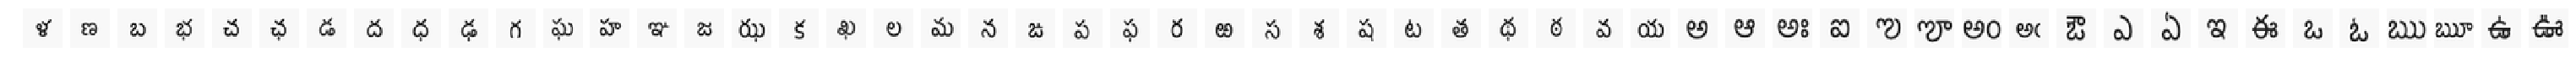

In [9]:
# plot images
plt.figure(figsize=(54, 1))
for i in range(54):
    plt.subplot(1,54,i+1)
    plt.imshow(images_array[i],cmap="gray")
    plt.axis("off")

In [0]:
# create a large dataset with duplicates 
labels = []
final_array = []
labels_array = []
for i,img in enumerate(images_array):
    for j in range(10000):
        final_array.append(img)
        labels_array.append(os.path.basename(images[i])[:-4])
final_array = np.array(final_array)
labels_array = np.array(labels_array)

In [0]:
# Label Encoding
le = LabelEncoder()
le.fit(labels_array)

def encode(le, labels):
    enc = le.transform(labels)
    return tf.keras.utils.to_categorical(enc, num_classes=54)
def decode(le, one_hot):
    dec = np.argmax(one_hot,axis=1)
    return le.inverse_transform(dec)

In [0]:
labels_array_en = encode(le, labels_array)

In [0]:
# split the dataset into train and test
X_train,X_test,Y_train,Y_test = train_test_split(final_array,labels_array_en,shuffle=True)

In [0]:
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')
# X_train = trainX.reshape(-1,28,28,1)
# X_test = testX.reshape(-1,28,28,1)

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [15]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(405000, 28, 28, 1) (135000, 28, 28, 1) (405000, 54) (135000, 54)


## Image agumentation

In [16]:
train_image_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    rotation_range=90,
    horizontal_flip=True, 
    vertical_flip=True,
    # rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2)
test_image_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    rotation_range=90,
    horizontal_flip=True, 
    vertical_flip=True,
    # rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2)

train_image_gen.fit(X_train, augment=True)
test_image_gen.fit(X_test, augment=True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


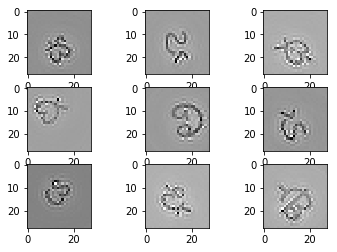

In [17]:
# plot images
for X_batch, y_batch in train_image_gen.flow(X_train, Y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [0]:
# lets set epochs and batch_size values
epochs = 10
batch_size = 128

## CNN

In [19]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(54, activation = "softmax"))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
____

In [0]:
# Build CNN
# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [21]:
checkpint = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/DLCP/telugu_script/talphabets_model.h5",save_best_only=True,verbose=1,monitor="val_acc",mode="max")
stoperly = tf.keras.callbacks.EarlyStopping(monitor="val_loss",mode="auto",verbose=1)
callbaklist = [checkpint,stoperly]
# model_history = model.fit(X_train_m3,trainy,validation_data=(X_test_m3,testy),epochs=10,batch_size=128,callbacks=callbaklist)
model_history = model.fit_generator(train_image_gen.flow(X_train, Y_train, batch_size=batch_size),validation_data=test_image_gen.flow(X_test, Y_test, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,validation_steps=len(X_test)/batch_size, epochs = 30,verbose = 1,callbacks=callbaklist)

Epoch 1/30
3164/3164 [============================>.] - ETA: 0s - loss: 1.1503 - acc: 0.6377
Epoch 00001: val_acc improved from -inf to 0.96660, saving model to /content/drive/My Drive/DLCP/telugu_script/talphabets_model.h5
3165/3164 [==============================] - 442s 140ms/step - loss: 1.1501 - acc: 0.6378 - val_loss: 0.1000 - val_acc: 0.9666
Epoch 2/30
3164/3164 [============================>.] - ETA: 0s - loss: 0.2088 - acc: 0.9324
Epoch 00002: val_acc improved from 0.96660 to 0.99848, saving model to /content/drive/My Drive/DLCP/telugu_script/talphabets_model.h5
3165/3164 [==============================] - 442s 140ms/step - loss: 0.2087 - acc: 0.9324 - val_loss: 0.0074 - val_acc: 0.9985
Epoch 3/30
3164/3164 [============================>.] - ETA: 0s - loss: 0.1289 - acc: 0.9623
Epoch 00003: val_acc did not improve from 0.99848
3165/3164 [==============================] - 439s 139ms/step - loss: 0.1289 - acc: 0.9623 - val_loss: 0.0064 - val_acc: 0.9983
Epoch 4/30
3164/3164 [===

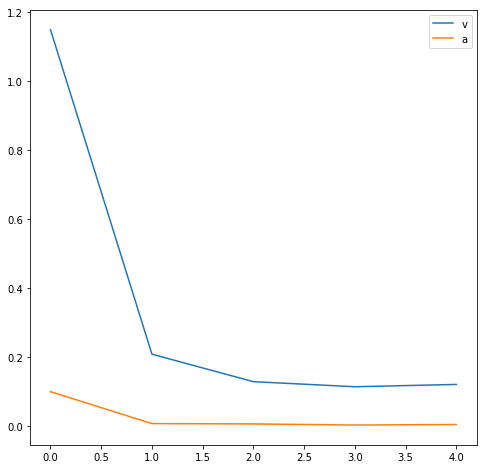

In [22]:
# plot train and test loss
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(model_history.history["loss"])
ax.legend("loss")
ax.plot(model_history.history["val_loss"])
ax.legend("val_loss")

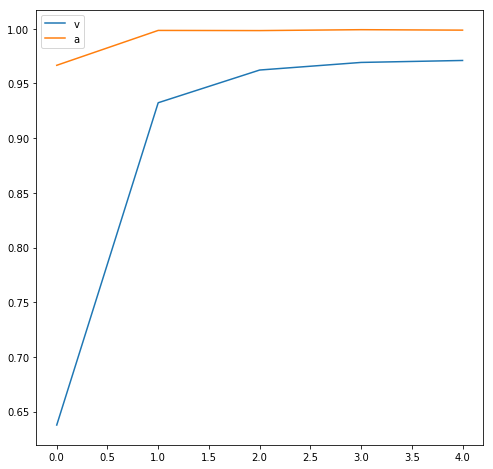

In [23]:
# plot train and test accuracy
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(model_history.history["acc"])
ax.legend("acc")
ax.plot(model_history.history["val_acc"])
ax.legend("val_acc")

In [24]:
# predict test accuracy
scores = model.evaluate(test_image_gen.flow(X_test, Y_test, batch_size=batch_size), verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.004903744342134823
Test accuracy: 0.9986445


In [0]:
# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return summed

In [26]:
# plot and print model prediciton 
#plt.figure(figsize=(10, 1))
for index in np.random.choice(25000,10):
    img = X_test[index]
    # plt.subplot(1,10,index+1)
    # plt.imshow(img,cmap="gray")
    # plt.axis("off")
    print("truth:",decode(le,[Y_test[index]]))
    pred = tta_prediction(test_image_gen,model,img,7)
    print("prediction:",decode(le,[pred]))

truth: ['gha']
prediction: ['gha']
truth: ['au']
prediction: ['au']
truth: ['da']
prediction: ['da']
truth: ['o']
prediction: ['o']
truth: ['e']
prediction: ['e']
truth: ['am']
prediction: ['am']
truth: ['aa']
prediction: ['aa']
truth: ['aa']
prediction: ['aa']
truth: ['uu']
prediction: ['uu']
truth: ['uu']
prediction: ['uu']


In [0]:
# from keras.models import load_model
# model = load_model('model.h5')
# model.load_weights('/content/drive/My Drive/DLCP/model.h5')
# pred = model.predict(X_test_m3[467].reshape(1,28,28,1))

# plt.figure(figsize=(10, 1))
# for index in np.random.choice(25000,10):
#     img = Image.open('data/' + str(index) + '.png').convert("L")
#     img = img.resize((28,28))
#     im2arr = np.array(img)
#     im2arr = X_test_m3[index]
#     im2arr = im2arr.reshape(1,28,28,1)
#     Predicting the Test set results
#     y_pred = model.predict(im2arr,batch_size=128)